In [ ]:
!pip install -U scikit-learn

     |████████████████████████████████| 6.8MB 2.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from math import log
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mutual_info_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import scale
from sklearn.utils import check_random_state
from sklearn.utils.fixes import _astype_copy_false
from sklearn.utils.validation import check_array, check_X_y
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.utils.multiclass import check_classification_targets
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from scipy import special, stats
from scipy.sparse import issparse
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import (as_float_array, check_array, check_X_y, safe_sqr,safe_mask)
from sklearn.utils.extmath import safe_sparse_dot, row_norms
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.feature_selection._base import SelectorMixin
from sklearn.metrics import roc_auc_score
from scipy.sparse import issparse
from scipy.special import digamma
import scipy.stats as stats
from subprocess import check_output
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:

def check_clusterings(labels_true, labels_pred):
    labels_true = check_array(
        labels_true, ensure_2d=False, ensure_min_samples=0, dtype=None,
    )
    labels_pred = check_array(
        labels_pred, ensure_2d=False, ensure_min_samples=0, dtype=None,
    )

    # input checks
    if labels_true.ndim != 1:
        raise ValueError(
            "labels_true must be 1D: shape is %r" % (labels_true.shape,))
    if labels_pred.ndim != 1:
        raise ValueError(
            "labels_pred must be 1D: shape is %r" % (labels_pred.shape,))
    check_consistent_length(labels_true, labels_pred)

    return labels_true, labels_pred

In [ ]:
def contingency_matrix(labels_true, labels_pred, *, eps=None, sparse=False):
    classes, class_idx = np.unique(labels_true, return_inverse=True)
    clusters, cluster_idx = np.unique(labels_pred, return_inverse=True)
    n_classes = classes.shape[0]
    n_clusters = clusters.shape[0]
    contingency = sp.coo_matrix((np.ones(class_idx.shape[0]),
                                 (class_idx, cluster_idx)),
                                shape=(n_classes, n_clusters),
                                dtype=np.int)
    if sparse:
        contingency = contingency.tocsr()
        contingency.sum_duplicates()
    else:
        contingency = contingency.toarray()
        if eps is not None:
            contingency = contingency + eps
    return contingency

In [ ]:
#importing dataset
df = pd.read_csv('leukemia.tab', delimiter='\t')
df.shape

(75, 5148)

In [ ]:
df.head()

,gene,AFFX-BioC-5_at,hum_alu_at,AFFX-DapX-M_at,AFFX-LysX-5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-HUMRGE/M10098_3_at,AFFX-HUMGAPDH/M33197_5_at,AFFX-HUMGAPDH/M33197_M_at,AFFX-HUMGAPDH/M33197_3_at,AFFX-HSAC07/X00351_5_at,AFFX-HSAC07/X00351_M_at,AFFX-HSAC07/X00351_3_at,AFFX-HUMTFRR/M11507_5_at,AFFX-HUMTFRR/M11507_M_at,AFFX-HUMTFRR/M11507_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-HSAC07/X00351_3_st,AFFX-HUMGAPDH/M33197_M_st,AFFX-HUMGAPDH/M33197_3_st,AFFX-HSAC07/X00351_M_st,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,AB000464_at,AB000467_at,AB000468_at,AB000584_at,AB000905_at,...,U10690_f_at,U22029_f_at,U49974_f_at,U65918_f_at,V00532_rna1_f_at,V00533_rna1_f_at,V01516_f_at,X13930_f_at,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,X03068_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,L10717_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,U29175_at,U48730_at,U58516_at,X06956_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,discrete,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,...,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous
1,class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ALL,88,15091,311,21,-13,215,797,14538,9738,8529,15076,11126,17782,16287,18727,15774,264,70,298,6750,6559,2982,132,546,336,151,72,281,36,-299,57,186,1647,137,803,-632,378,-26,155,...,246,26,63,60,-20,-30,488,504,391,-763,172,149,341,788,21210,13771,598,396,245,14476,10882,2762,-67,346,-68,229,108,349,61,273,384,1582,185,511,389,793,329,36,191,-37
3,ALL,283,11038,134,-21,-219,116,433,615,115,1518,19448,13568,18112,17926,20668,16959,513,153,285,2215,3824,3187,301,530,418,263,21,250,43,-103,169,219,2043,188,756,-700,249,-242,131,...,394,-83,153,18,3,-135,518,440,200,51,154,418,433,736,21059,15097,563,171,-149,13686,11789,1567,-88,290,14,194,303,214,-28,143,231,624,169,837,442,782,295,11,76,-14
4,ALL,309,16692,378,67,104,476,1474,5669,3272,3668,27410,16756,23006,22626,24672,18285,609,66,187,3325,3349,3097,524,911,761,88,-27,358,42,142,359,237,1997,91,2514,-603,362,-31,270,...,383,36,157,28,12,-213,426,687,387,-474,180,272,591,959,24292,17378,1808,363,325,6560,5023,1090,9,220,-58,294,143,464,513,238,720,753,315,1199,168,1138,777,41,228,-41


In [ ]:
df=df.dropna().loc[1:,:]

In [ ]:
X = df.drop(['gene'], axis=1)
X.head()

,AFFX-BioC-5_at,hum_alu_at,AFFX-DapX-M_at,AFFX-LysX-5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-HUMRGE/M10098_3_at,AFFX-HUMGAPDH/M33197_5_at,AFFX-HUMGAPDH/M33197_M_at,AFFX-HUMGAPDH/M33197_3_at,AFFX-HSAC07/X00351_5_at,AFFX-HSAC07/X00351_M_at,AFFX-HSAC07/X00351_3_at,AFFX-HUMTFRR/M11507_5_at,AFFX-HUMTFRR/M11507_M_at,AFFX-HUMTFRR/M11507_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-HSAC07/X00351_3_st,AFFX-HUMGAPDH/M33197_M_st,AFFX-HUMGAPDH/M33197_3_st,AFFX-HSAC07/X00351_M_st,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,AB000464_at,AB000467_at,AB000468_at,AB000584_at,AB000905_at,AB001106_at,...,U10690_f_at,U22029_f_at,U49974_f_at,U65918_f_at,V00532_rna1_f_at,V00533_rna1_f_at,V01516_f_at,X13930_f_at,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,X03068_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,L10717_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,U29175_at,U48730_at,U58516_at,X06956_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
2,88,15091,311,21,-13,215,797,14538,9738,8529,15076,11126,17782,16287,18727,15774,264,70,298,6750,6559,2982,132,546,336,151,72,281,36,-299,57,186,1647,137,803,-632,378,-26,155,355,...,246,26,63,60,-20,-30,488,504,391,-763,172,149,341,788,21210,13771,598,396,245,14476,10882,2762,-67,346,-68,229,108,349,61,273,384,1582,185,511,389,793,329,36,191,-37
3,283,11038,134,-21,-219,116,433,615,115,1518,19448,13568,18112,17926,20668,16959,513,153,285,2215,3824,3187,301,530,418,263,21,250,43,-103,169,219,2043,188,756,-700,249,-242,131,431,...,394,-83,153,18,3,-135,518,440,200,51,154,418,433,736,21059,15097,563,171,-149,13686,11789,1567,-88,290,14,194,303,214,-28,143,231,624,169,837,442,782,295,11,76,-14
4,309,16692,378,67,104,476,1474,5669,3272,3668,27410,16756,23006,22626,24672,18285,609,66,187,3325,3349,3097,524,911,761,88,-27,358,42,142,359,237,1997,91,2514,-603,362,-31,270,603,...,383,36,157,28,12,-213,426,687,387,-474,180,272,591,959,24292,17378,1808,363,325,6560,5023,1090,9,220,-58,294,143,464,513,238,720,753,315,1199,168,1138,777,41,228,-41
5,12,15763,268,43,-148,155,415,4850,2293,2569,14920,11439,17633,15770,18773,14245,183,-54,260,3058,2442,1731,-76,327,511,484,61,118,39,-11,274,245,2128,-82,1489,-909,266,-181,115,255,...,223,-46,90,-19,-36,-87,534,376,317,-336,325,149,173,431,17558,13818,576,455,594,8955,9567,1708,45,430,-35,128,22,342,142,277,307,743,240,835,174,627,170,-50,126,-91
6,168,18128,118,-8,-55,122,483,1284,2731,316,14653,15030,17384,16386,19091,18323,291,78,287,1130,1056,728,89,120,65,118,16,197,39,237,311,186,1608,204,322,-254,554,16,45,569,...,139,45,-29,23,-20,-104,325,299,162,-56,279,183,259,605,18530,15619,65,122,126,8443,8512,1503,29,159,18,71,44,159,71,134,178,626,156,649,504,250,314,14,56,-25


In [ ]:
# Mapping genes into integers
y = df['gene']
y=y.map({'ALL': 1, 'AML': 0})
y.head()

2    1
3    1
4    1
5    1
6    1
Name: gene, dtype: int64

In [ ]:
df.dtypes

gene              object
AFFX-BioC-5_at    object
hum_alu_at        object
AFFX-DapX-M_at    object
AFFX-LysX-5_at    object
                   ...  
X83863_at         object
Z17240_at         object
L49218_f_at       object
M71243_f_at       object
Z78285_f_at       object
Length: 5148, dtype: object

In [ ]:
print(X.shape)
print(y.shape)

(72, 5147)
(72,)


In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((57, 5147), (57,), (15, 5147), (15,))

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X_train)
X_train_filter = constant_filter.transform(X_train)
X_test_filter = constant_filter.transform(X_test)

In [ ]:
X_train_T = X_train_filter.T
X_test_T = X_test_filter.T
X_train_T = pd.DataFrame(X_train_T)
X_test_T = pd.DataFrame(X_test_T)

In [ ]:
X_train_T.duplicated().sum()

0

In [ ]:
duplicated_features = X_train_T.duplicated()

In [ ]:
features_to_keep = [not index for index in duplicated_features]
X_train_unique = X_train_T[features_to_keep].T
X_test_unique = X_test_T[features_to_keep].T
X_train_unique.shape, X_test_unique.shape

((57, 5147), (15, 5147))

In [ ]:
#Function for KNN Classifier C1
from sklearn.neighbors import KNeighborsClassifier
def run_knn(X_train, X_test, y_train, y_test):
    c1 =KNeighborsClassifier(n_neighbors=3)
    c1.fit(X_train, y_train)
    y_pred = c1.predict(X_train)
    y_test_pred=c1.predict(X_test)
    print('Training 80% data report::')
    print('Accuracy Score: ')
    print(accuracy_score(y_train, y_pred))
    print('F1-Score: ')
    print(f1_score(y_train, y_pred))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_train, y_pred))
    print('Testing 20% data report::')
    print('Accuracy Score: ')
    print(accuracy_score(y_test, y_test_pred))
    print('F1-Score: ')
    print(f1_score(y_test, y_test_pred))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, y_test_pred))


In [ ]:
#Function for SVM Classifier C2
def run_svm(X_train, X_test, y_train, y_test):
    c2 =svm.SVC()
    c2.fit(X_train, y_train)
    y_pred = c2.predict(X_train)
    y_test_pred=c2.predict(X_test)
    print('Training 80% data report::')
    print('Accuracy Score: ')
    print(accuracy_score(y_train, y_pred))
    print('F1-Score: ')
    print(f1_score(y_train, y_pred))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_train, y_pred))
    print('Testing 20% data report::')
    print('Accuracy Score: ')
    print(accuracy_score(y_test, y_test_pred))
    print('F1-Score: ')
    print(f1_score(y_test, y_test_pred))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, y_test_pred))

## Classification without feature selection

In [ ]:
%%time
run_knn(X_train_unique, X_test_unique, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9649122807017544
F1-Score: 
0.972972972972973
Confusion Matrix: 
[[19  1]
 [ 1 36]]
Testing 20% data report::
Accuracy Score: 
1.0
F1-Score: 
1.0
Confusion Matrix: 
[[ 5  0]
 [ 0 10]]
CPU times: user 200 ms, sys: 10 ms, total: 210 ms
Wall time: 211 ms


In [ ]:
%%time
run_svm(X_train_unique, X_test_unique, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9298245614035088
F1-Score: 
0.9487179487179488
Confusion Matrix: 
[[16  4]
 [ 0 37]]
Testing 20% data report::
Accuracy Score: 
0.9333333333333333
F1-Score: 
0.9523809523809523
Confusion Matrix: 
[[ 4  1]
 [ 0 10]]
CPU times: user 201 ms, sys: 4.13 ms, total: 205 ms
Wall time: 202 ms


## Task A.1: Application of Mutual Information based feature selection(f1)

In [ ]:
# Functions of Mutual information

def mutual_info_score(labels_true, labels_pred, *, contingency=None):
    if contingency is None:
        labels_true, labels_pred = check_clusterings(labels_true, labels_pred)
        contingency = contingency_matrix(labels_true, labels_pred, sparse=True)
    else:
        contingency = check_array(contingency,
                                  accept_sparse=['csr', 'csc', 'coo'],
                                  dtype=[int, np.int32, np.int64])
    if isinstance(contingency, np.ndarray):
        nzx, nzy = np.nonzero(contingency)
        nz_val = contingency[nzx, nzy]
    elif sp.issparse(contingency):
        nzx, nzy, nz_val = sp.find(contingency)

    contingency_sum = contingency.sum()
    pi = np.ravel(contingency.sum(axis=1))
    pj = np.ravel(contingency.sum(axis=0))
    log_contingency_nm = np.log(nz_val)
    contingency_nm = nz_val / contingency_sum
    outer = (pi.take(nzx).astype(np.int64, copy=False)
             * pj.take(nzy).astype(np.int64, copy=False))
    log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())
    mi = (contingency_nm * (log_contingency_nm - log(contingency_sum)) +
          contingency_nm * log_outer)
    return np.clip(mi.sum(), 0.0, None)

In [ ]:
#driver code
def _compute_mi(x, y, n_neighbors=3):
        return mutual_info_score(x, y)

def _iterate_columns(X, columns=None):
    if columns is None:
        columns = range(X.shape[1])

    if issparse(X):
        for i in columns:
            x = np.zeros(X.shape[0])
            start_ptr, end_ptr = X.indptr[i], X.indptr[i + 1]
            x[X.indices[start_ptr:end_ptr]] = X.data[start_ptr:end_ptr]
            yield x
    else:
        for i in columns:
            yield X[:, i]


def _estimate_mi(X, y,n_neighbors=3):
    X, y = check_X_y(X, y, accept_sparse='csc')
    n_samples, n_features = X.shape
    discrete_features = issparse(X)
    discrete_mask = np.empty(n_features, dtype=bool)
    discrete_mask.fill(discrete_features)
    
    mi = [_compute_mi(x, y, n_neighbors) for
          x, discrete_feature in zip(_iterate_columns(X), discrete_mask)]

    return np.array(mi)

def mutual_info_classifier(X, y, n_neighbors=3,):
    check_classification_targets(y)
    return _estimate_mi(X, y, n_neighbors)

In [ ]:
mi = mutual_info_classifier(X_train_unique, y_train) 
len(mi)

5147

In [ ]:
mi[: 10]

array([0.62366701, 0.64798797, 0.5750251 , 0.55666552, 0.62366701,
       0.55070415, 0.59934606, 0.59934606, 0.62366701, 0.62366701])

In [ ]:
mi = pd.Series(mi)
mi.index = X_train_unique.columns

In [ ]:
mi.sort_values(ascending=False, inplace = True)

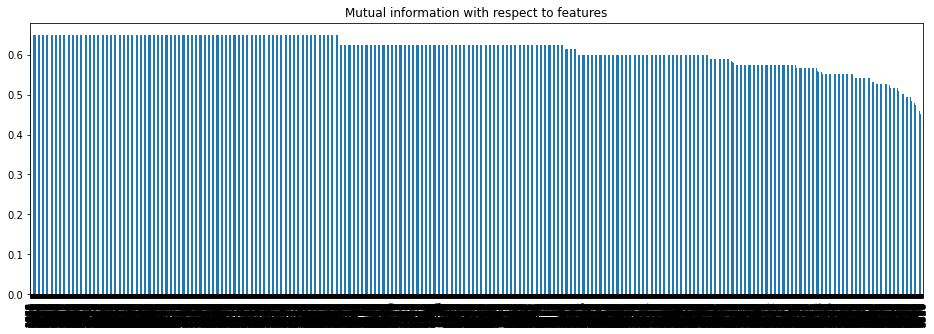

In [ ]:
plt.title('Mutual information with respect to features')
mi.plot.bar(figsize = (16,5))
plt.show()

In [ ]:
sel = SelectPercentile(mutual_info_classifier, percentile=10).fit(X_train_unique, y_train)
X_train_unique.columns[sel.get_support()]

Int64Index([   1,   10,   11,   12,   13,   14,   15,   16,   19,   21,
            ...
            1564, 1571, 1572, 1579, 1583, 1584, 1586, 1590, 1593, 1604],
           dtype='int64', length=514)

In [ ]:
len(X_train_unique.columns[sel.get_support()])

514

In [ ]:
X_train_mi = sel.transform(X_train_unique)
X_test_mi = sel.transform(X_test_unique)
X_train_mi.shape

(57, 514)

## Application Of KNN with 3 neighbors(C1)

In [ ]:
%%time
run_knn(X_train_mi, X_test_mi, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9824561403508771
F1-Score: 
0.9866666666666666
Confusion Matrix: 
[[19  1]
 [ 0 37]]
Testing 20% data report::
Accuracy Score: 
1.0
F1-Score: 
1.0
Confusion Matrix: 
[[ 5  0]
 [ 0 10]]
CPU times: user 31 ms, sys: 2.05 ms, total: 33.1 ms
Wall time: 38.8 ms


## Application Of SVM (C2)



In [ ]:
%%time
run_svm(X_train_mi, X_test_mi, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9298245614035088
F1-Score: 
0.9487179487179488
Confusion Matrix: 
[[16  4]
 [ 0 37]]
Testing 20% data report::
Accuracy Score: 
0.9333333333333333
F1-Score: 
0.9523809523809523
Confusion Matrix: 
[[ 4  1]
 [ 0 10]]
CPU times: user 30.6 ms, sys: 1.13 ms, total: 31.7 ms
Wall time: 29.2 ms


## Task A.2: Application of F Classifier based feature selection(f2)

In [ ]:
#Functions for F classifier 
def f_oneway(*args):
    n_classes = len(args)
    args = [as_float_array(a) for a in args]
    n_samples_per_class = np.array([a.shape[0] for a in args])
    n_samples = np.sum(n_samples_per_class)
    ss_alldata = sum(safe_sqr(a).sum(axis=0) for a in args)
    sums_args = [np.asarray(a.sum(axis=0)) for a in args]
    square_of_sums_alldata = sum(sums_args) ** 2
    square_of_sums_args = [s ** 2 for s in sums_args]
    sstot = ss_alldata - square_of_sums_alldata / float(n_samples)
    ssbn = 0.
    for k, _ in enumerate(args):
        ssbn += square_of_sums_args[k] / n_samples_per_class[k]
    ssbn -= square_of_sums_alldata / float(n_samples)
    sswn = sstot - ssbn
    dfbn = n_classes - 1
    dfwn = n_samples - n_classes
    msb = ssbn / float(dfbn)
    msw = sswn / float(dfwn)
    constant_features_idx = np.where(msw == 0.)[0]
    f = msb / msw #High variance upon low variance 
    # flatten matrix to vector in sparse case
    f = np.asarray(f).ravel()
    prob = special.fdtrc(dfbn, dfwn, f)
    return f, prob


def f_classif(X, y):
    X, y = check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'])
    args = [X[safe_mask(X, y == k)] for k in np.unique(y)]
    return f_oneway(*args)

In [ ]:
fc= f_classif(X_train, y_train) 
len(mi)

5147

In [ ]:
fc[: 10]

(array([7.27230443, 2.54311235, 0.26106612, ..., 0.64247832, 5.08636676,
        0.21048496]),
 array([0.00927583, 0.11650721, 0.61143363, ..., 0.42626428, 0.02811434,
        0.6481955 ]))

In [ ]:
#from sklearn.feature_selection import chi2, f_classif
fvalue_selector = SelectPercentile(f_classif, percentile = 10)

In [ ]:
features_kbest = fvalue_selector.fit_transform(X_train_unique, y_train)

In [ ]:
X_train_fc = fvalue_selector.transform(X_train_unique)
X_test_fc = fvalue_selector.transform(X_test_unique)
X_train_fc.shape

(57, 515)

## Application Of KNN (C1)

In [ ]:
%%time
run_knn(X_train_fc, X_test_fc, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9649122807017544
F1-Score: 
0.9736842105263158
Confusion Matrix: 
[[18  2]
 [ 0 37]]
Testing 20% data report::
Accuracy Score: 
0.9333333333333333
F1-Score: 
0.9523809523809523
Confusion Matrix: 
[[ 4  1]
 [ 0 10]]
CPU times: user 27.7 ms, sys: 4.04 ms, total: 31.8 ms
Wall time: 30 ms


## Application Of SVM (C2)

In [ ]:
%%time
run_svm(X_train_fc, X_test_fc, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9824561403508771
F1-Score: 
0.9866666666666666
Confusion Matrix: 
[[19  1]
 [ 0 37]]
Testing 20% data report::
Accuracy Score: 
1.0
F1-Score: 
1.0
Confusion Matrix: 
[[ 5  0]
 [ 0 10]]
CPU times: user 25.5 ms, sys: 3.96 ms, total: 29.5 ms
Wall time: 27.3 ms


## Task A.3: Application of T test based feature selection(f3)

In [ ]:
#Functions for  t-test 
import math
def t_oneway(*args):
    n_classes = len(args)
    args = [as_float_array(a) for a in args]
    n_samples_per_class = np.array([a.shape[0] for a in args])
    n_samples = np.sum(n_samples_per_class)
    ss_alldata = sum(safe_sqr(a).sum(axis=0) for a in args)
    sums_args = [np.asarray(a.sum(axis=0)) for a in args]
    square_of_sums_alldata = sum(sums_args) ** 2
    square_of_sums_args = [s ** 2 for s in sums_args]
    sstot = ss_alldata - square_of_sums_alldata / float(n_samples)
    ssbn = 0.
    for k, _ in enumerate(args):
        ssbn += square_of_sums_args[k] / n_samples_per_class[k]
    ssbn -= square_of_sums_alldata / float(n_samples)
    sswn = sstot - ssbn
    dfbn = n_classes - 1
    dfwn = n_samples - n_classes
    msb = ssbn / float(dfbn)
    msw = sswn / float(dfwn)
    constant_features_idx = np.where(msw == 0.)[0]
    t = (ssbn-sswn)**2/ (msb+msw) #Taking sqrt of t value instead of absolute as t due to limitation of numpy. t^2= (absolute differences of means/sum of variances)^2
    # flatten matrix to vector in sparse case
    t = np.asarray(t).ravel()
    prob = special.fdtrc(dfbn, dfwn, t)
    return t, prob


def t_test(X, y):
    X, y = check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'])
    args = [X[safe_mask(X, y == k)] for k in np.unique(y)]
    return t_oneway(*args)

In [ ]:
tt= t_test(X_train, y_train) 
len(tt)

2

In [ ]:
tt[: 10]

(array([2.89439079e+06, 9.73510051e+10, 4.30257673e+07, ...,
        4.14923672e+06, 1.28390453e+08, 4.52521949e+06]),
 array([1.57294534e-131, 5.13329967e-256, 9.16656362e-164, ...,
        7.86099172e-136, 8.03717832e-177, 7.23645335e-137]))

In [ ]:
#from sklearn.feature_selection import chi2, f_classif
tvalue_selector = SelectPercentile(t_test, percentile = 10)

In [ ]:
featurestt_kbest = tvalue_selector.fit_transform(X_train_unique, y_train)

In [ ]:
X_train_t = tvalue_selector.transform(X_train_unique)
X_test_t = tvalue_selector.transform(X_test_unique)
X_train_t.shape

(57, 515)

## Application Of KNN (C1)

In [ ]:
%%time
run_knn(X_train_t, X_test_t, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9473684210526315
F1-Score: 
0.9599999999999999
Confusion Matrix: 
[[18  2]
 [ 1 36]]
Testing 20% data report::
Accuracy Score: 
0.8666666666666667
F1-Score: 
0.9090909090909091
Confusion Matrix: 
[[ 3  2]
 [ 0 10]]
CPU times: user 28.7 ms, sys: 2.08 ms, total: 30.8 ms
Wall time: 29 ms


## Application Of SVM (C2)

In [ ]:
%%time
run_svm(X_train_t, X_test_t, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.8070175438596491
F1-Score: 
0.8705882352941177
Confusion Matrix: 
[[ 9 11]
 [ 0 37]]
Testing 20% data report::
Accuracy Score: 
0.7333333333333333
F1-Score: 
0.8333333333333333
Confusion Matrix: 
[[ 1  4]
 [ 0 10]]
CPU times: user 24.9 ms, sys: 4.09 ms, total: 29 ms
Wall time: 26.6 ms


### End of Task A